In [147]:
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import cv2
from skimage.transform import rescale
import string

from matplotlib import pyplot as plt
# Plot inline
%matplotlib inline

img_path = "../data/man_outline.jpg"
kernel_size = 5

chars = " .,=+-_^<>()[]{|}\\!/"
# chars = " #$&%.,=*+-_^<>()[]{|}\\!/"
# chars = " !\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
charsTest = "?{|"

In [148]:
def getCharImages(chars, font_path=None):
    # font_path = font_path or "./fonts/SFMono-Medium.otf"
    # try:
    #     font = ImageFont.truetype(font_path, size=200)
    #     font_size = font.getsize(string.printable)[1]
    # except IOError:
    font = ImageFont.load_default()
    font_size = font.getsize(string.printable)[1]
    # print("Warning: Could not use chosen font. Using default.")

    charImgs = []
    for char in chars:
        # init image
        char_w = font.getsize(char)[0]
        char_h = font_size
        image = Image.new("L", (char_w, char_h), color=0)

        # draw text to image
        draw = ImageDraw.Draw(image)
        draw.text((0, 0), char, fill=255, font=font, spacing=0)

        # convert image to np array
        charImgs.append(np.array(image))

    return np.array(charImgs)


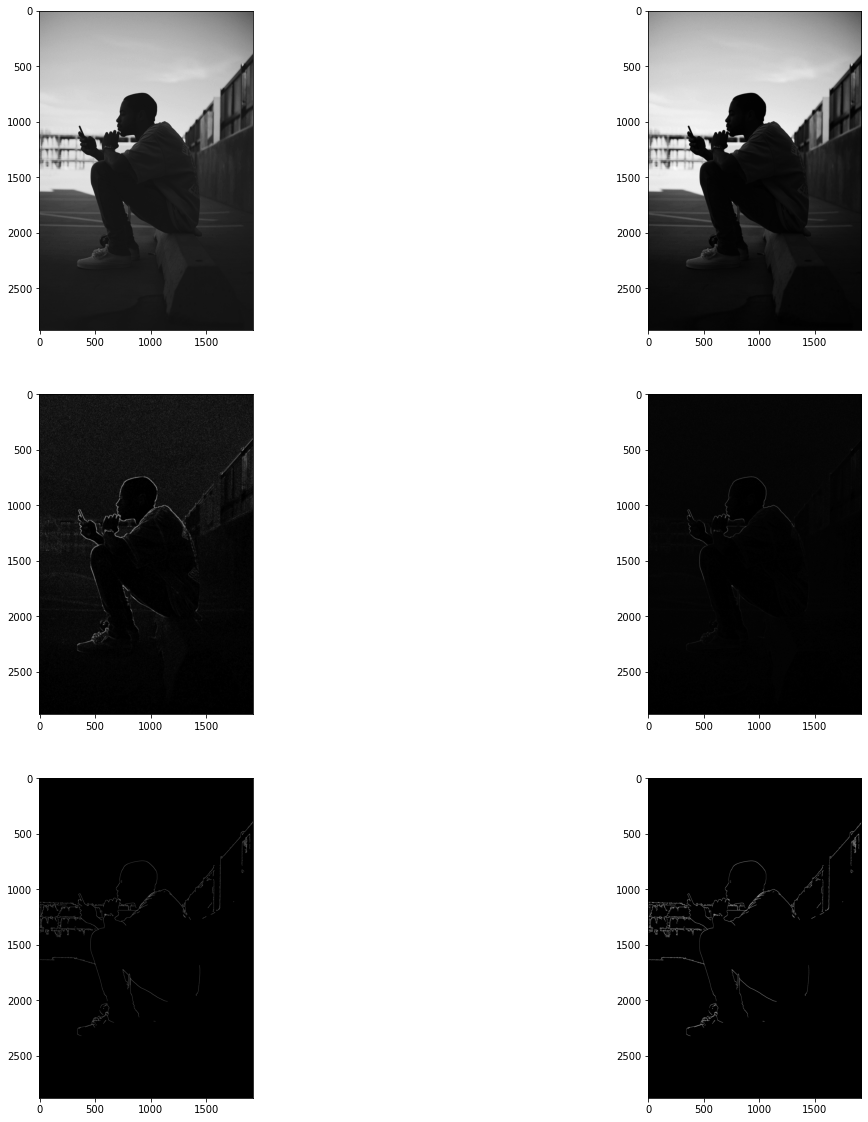

In [155]:
img = cv2.imread(img_path, 0)

blur_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

sobel_img = cv2.Sobel(
    src=blur_img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5
)  # Combined X and Y Sobel Edge Detection

sobel_img = np.absolute(sobel_img)
sobel_img = np.uint8(sobel_img)

# laplacian
laplacian_img = cv2.Laplacian(
    src=blur_img, ddepth=cv2.CV_64F, ksize=1
)  # Combined X and Y Sobel Edge Detection

laplacian_img = np.absolute(laplacian_img)
laplacian_img = np.uint8(laplacian_img)

# canny 
canny_img = cv2.Canny(blur_img, 40, 100)

# dileted canny 
canny_dilated = cv2.dilate(canny_img, (5,5))

# plot
plt.figure(figsize=(20,20))

plt.subplot(321)
plt.imshow(img, cmap="gray")
plt.subplot(322)
plt.imshow(blur_img, cmap="gray")
plt.subplot(323)
plt.imshow(sobel_img, cmap="gray")
plt.subplot(324)
plt.imshow(laplacian_img, cmap="gray")
plt.subplot(325)
plt.imshow(canny_img, cmap="gray")
plt.subplot(326)
plt.imshow(canny_dilated, cmap="gray")
plt.show()

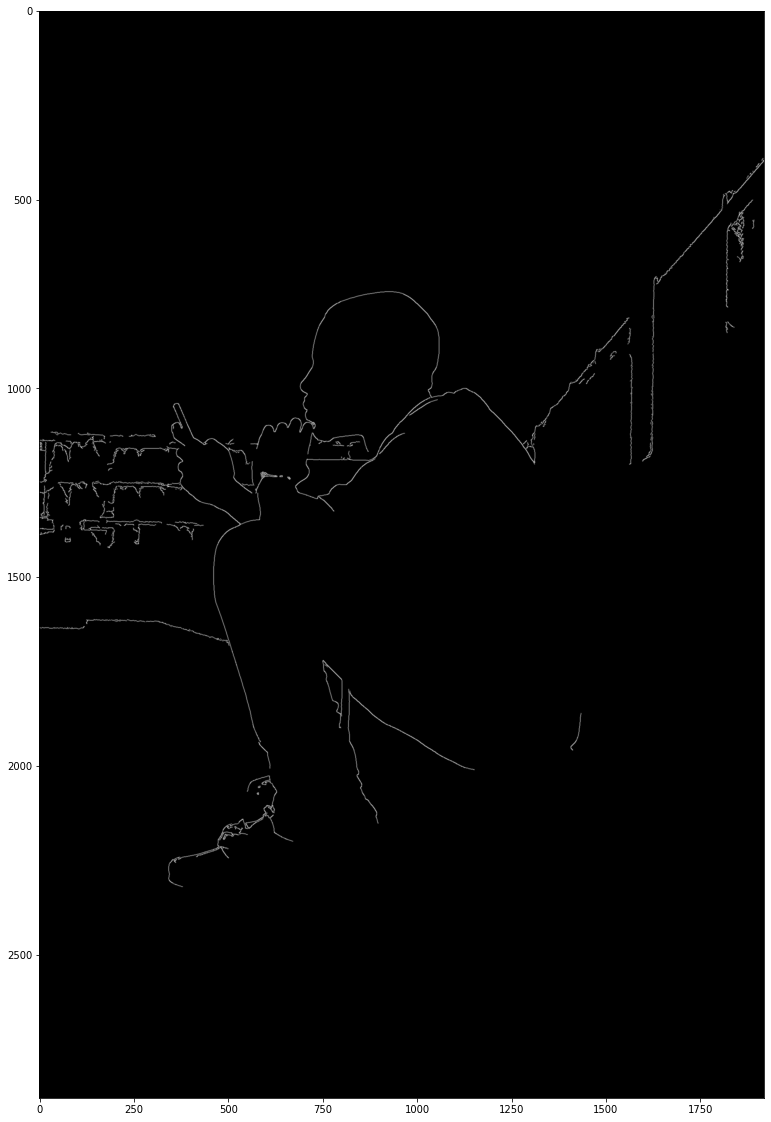

chars resized: (20, 22, 12)
num of chars: 20
(20, 11, 6)
130 160


In [153]:
# get char images 
char_dict = getCharImages(chars=chars)

# print(canny_dilated.max(), canny_dilated.min())
selected_img = canny_img

resize_factor = 1
resize_w = int(selected_img.shape[1] * resize_factor)
resize_h = int(selected_img.shape[0] * resize_factor)
resized_img = cv2.resize(selected_img, (resize_w, resize_h))

# blur_canny_dilated = cv2.medianBlur(resized_img, 7)

blur_canny_dilated = cv2.GaussianBlur(resized_img, (3, 3), 0)
# blur_canny_dilated = resized_img

plt.figure(figsize=(20,20))
plt.imshow(blur_canny_dilated, cmap="gray")
plt.show()


# store dimensions
cols = 160

_, char_h, char_w = char_dict.shape
img_h, img_w = blur_canny_dilated.shape
# rows, cols = img_h // char_h, img_w // char_w

# compute number of rows
rows = int(img_h * (char_w / char_h) * cols / img_w)
# compute width of tile
w = int(img_w / cols)
# compute tile height based on aspect ratio and scale
h = int(img_w / ((char_w / char_h) * cols))


char_dict_resized = []
for char_kernel in char_dict:
  char_dict_resized.append(cv2.resize(char_kernel, (w, h)))
char_dict_resized = np.array(char_dict_resized)

print(f"chars resized: {char_dict_resized.shape}")





print(f"num of chars: {len(chars)}")
print(char_dict.shape)
print(rows, cols)


out_chars = []
for i in range(rows):
  row_str = ""
  for j in range(cols):
    sample = blur_canny_dilated[i*h:(i+1)*h,j*w:(j+1)*w]
    # sample = np.ones((char_h, char_w)) * 255
    euclidean_norms = np.linalg.norm(char_dict_resized - sample, axis=(1,2))
    char_i = np.argmin(euclidean_norms)
    # print(f"sample: {sample.shape}")
    # print(f"norms: {euclidean_norms.shape}")
    # print(f"index: {char_i}")
    
    row_str += chars[char_i]
  
  out_chars.append(row_str)
    

char size = (7, 14)


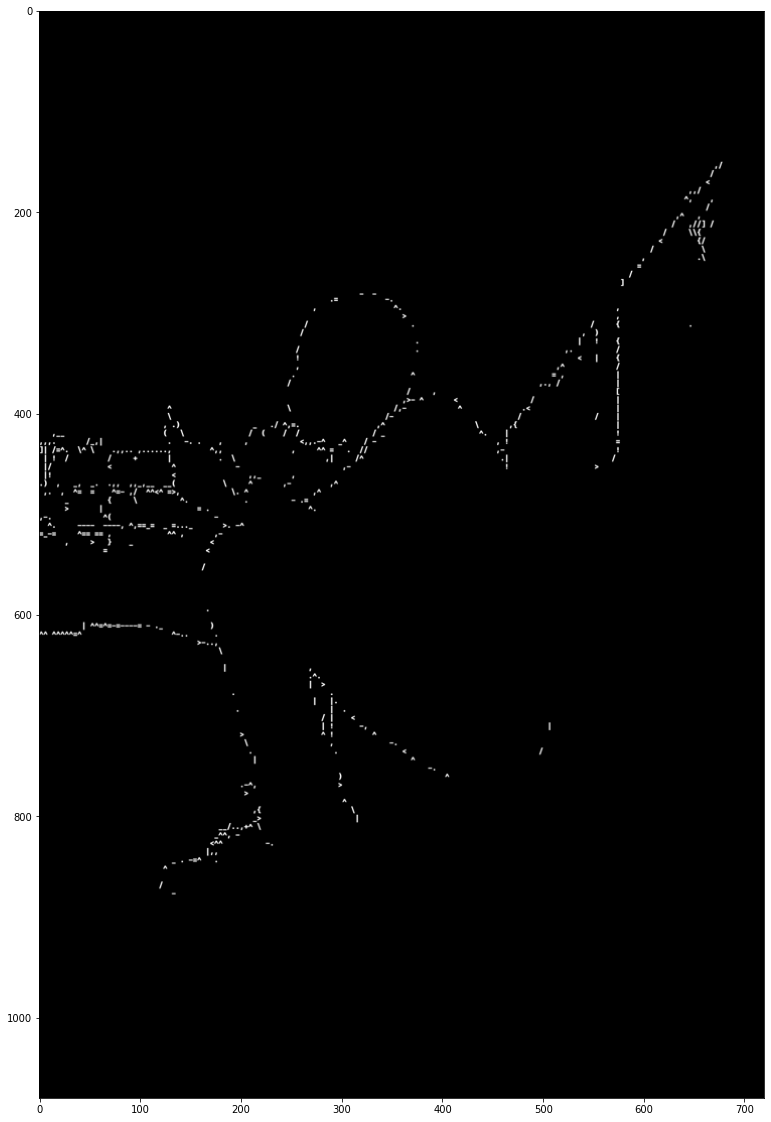

In [154]:
def autoSize(height, width, resolution=1080):
    """Determines the size of an image by setting the largest side to the size of the resolution"""
    if width >= height:
        size = (round((resolution / width) * height), resolution)
    else:
        size = (resolution, round((resolution / height) * width))
    return size

def textToImage(aimg, inverted, size, char_ratio, bg_color=None, font_path=None):
    """
    Convert character and color arrays to an ASCII image.

    arguments:
    aimg - the array of characters to be converted to an image
    cimg - the array of colors coresponding to a char in aimg
    inverted - if the backgroung should be black or white
    size - size of the outputed image
    bg_color - color of background (set to default based on the value of 'inverted')
    font_path - path to a font file (for example impact.ttf)
    """

    # choose a font
    if inverted:
        default_font_path = "../fonts/SFMono-Medium.otf"
    else:
        default_font_path = "../fonts/SFMono-Heavy.otf"
    font_path = font_path or default_font_path
    font_size = round((3 / 4) * (2 * size[0] / len(aimg)))
    try:
        font = ImageFont.truetype(font_path, size=font_size)
    except IOError:
        font = ImageFont.load_default()
        print("Warning: Could not use chosen font. Using default.")

    # char height is adjusted based on output size and col:row ratio
    line_width = font.getsize("".join(aimg[0]))[0]  # get line width
    char_width = round(line_width / len(aimg[0]))
    char_height = round((size[0] / size[1]) * (line_width / len(aimg)))
    
    print(f"char size = ({char_width}, {char_height})")

    # create new image
    height = round(char_height * len(aimg))
    width = round(line_width)
    bg_color = bg_color
    image = Image.new("L", (width, height), color=bg_color)
    draw = ImageDraw.Draw(image)

    # draw each line of text
    vert_pos = 0
    line_spacing = char_height
    char_spacing = char_width

    # draw each char to image
    for line in aimg:
        hor_pos = 0
        for c in line:
            draw.text((hor_pos, vert_pos), c, fill=255, font=font)
            hor_pos += char_spacing
        vert_pos += line_spacing

    return image.resize((size[1], size[0]))

out_img = textToImage(out_chars, False, autoSize(img.shape[0], img.shape[1]), 0)

plt.figure(figsize=(20,20))
plt.imshow(out_img, cmap="gray")
plt.show()